In [1]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt

import helper

In [45]:
# Number of system qubits; this determines the size of the matrix A and vector b
n_qubits = 3

print(type(n_qubits))

# Number of quantum measurements performed to get a probability distribution of results
n_shots = 10**6

# Total number of qubits; here we add an ancillary qubit
tot_qubits = n_qubits + 1

# Index of ancillary qubit (Python lists are 0-indexed)
ancilla_idx = n_qubits

# Number of optimization steps
steps = 30

# Learning rate of optimization algorithm
# TODO: hyperparameter tuning for eta (think coarse to fine)
eta = 0.8

# Initial spread of random quantum weights
q_delta = 0.001

# Seed for RNG
rng_seed = 0

<class 'int'>


In [48]:
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = np.array([1.0, 0.2, 0.2])
print(type(c))
print(len(c))



def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    
    # This loop applies the Hadamard operator on each wire
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

# TODO: Given A written in linear combination form, form controlled versions of unitary components
# Refer to Ryan LaRose notebook, "IZX" notation, then convert to matrix version + controlled unitaries

# Q: Why controlled versions necessary? Is it for measurement?

# TODO: Can write a function that, given an A, find what are the required A_l components?
# This function gives the components of A
def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        # CNOT gate is the same as controlled Pauli-X gate
        qml.CNOT(wires=[ancilla_idx, 0])
        qml.CZ(wires=[ancilla_idx, 1])

    elif idx == 2:
        qml.CNOT(wires=[ancilla_idx, 0])


<class 'pennylane.numpy.tensor.tensor'>
3


In [4]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    # We first prepare an equal superposition of all the states of the computational basis.
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit.
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)

In [5]:
# TODO: this is what we vary to access different devices (like IBM, Rigetti etc.)
# Loads a particular quantum device
# 'default.qubit' is a simple state simulator
# 'wires' is a aparamter specifying the number of wires (subsytems) to initialise the device with
dev_mu = qml.device("default.qubit", wires=tot_qubits)


# Quantum node contains a quantum function (in this case, local_hadamard_test) and the computational 
# device it's executed on (in this case, dev_mu)
@qml.qnode(dev_mu, interface="autograd")
# For this function, l, lp, j are the indices for the mu coefficients
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    # In this specific example Adjoint(U_b) = U_b.
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

In [6]:
# Computes the mu coefficients
def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

In [7]:
def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

In [8]:
def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

In [9]:
np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits, requires_grad=True)

opt = qml.GradientDescentOptimizer(eta)

cost_history = []
for it in range(steps):
    w, cost = opt.step_and_cost(cost_loc, w)
    print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
    cost_history.append(cost)

Step   0       Cost_L = 0.0089888
Step   1       Cost_L = 0.0070072
Step   2       Cost_L = 0.0054157
Step   3       Cost_L = 0.0041528
Step   4       Cost_L = 0.0031617
Step   5       Cost_L = 0.0023917
Step   6       Cost_L = 0.0017988
Step   7       Cost_L = 0.0013461
Step   8       Cost_L = 0.0010028
Step   9       Cost_L = 0.0007442
Step  10       Cost_L = 0.0005503
Step  11       Cost_L = 0.0004058
Step  12       Cost_L = 0.0002984
Step  13       Cost_L = 0.0002190
Step  14       Cost_L = 0.0001604
Step  15       Cost_L = 0.0001173
Step  16       Cost_L = 0.0000857
Step  17       Cost_L = 0.0000625
Step  18       Cost_L = 0.0000455
Step  19       Cost_L = 0.0000331
Step  20       Cost_L = 0.0000241
Step  21       Cost_L = 0.0000175
Step  22       Cost_L = 0.0000127
Step  23       Cost_L = 0.0000092
Step  24       Cost_L = 0.0000067
Step  25       Cost_L = 0.0000049
Step  26       Cost_L = 0.0000035
Step  27       Cost_L = 0.0000026
Step  28       Cost_L = 0.0000019
Step  29      

C:\Users\writi\AppData\Local\Temp\ipykernel_12484\1714839985.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


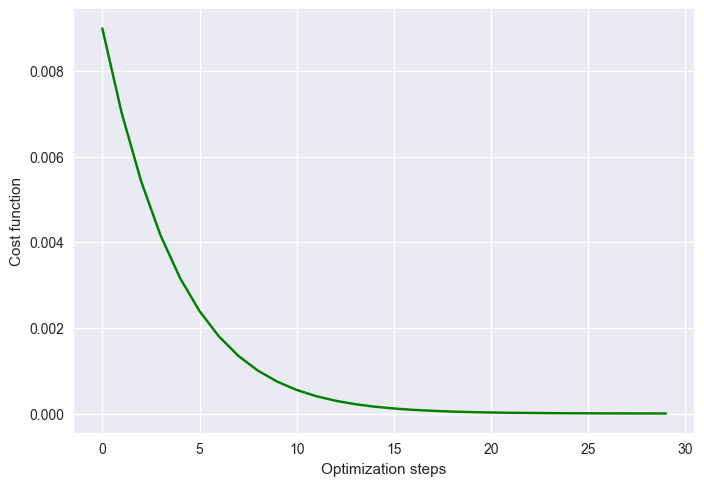

In [10]:
plt.style.use("seaborn")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

In [11]:
# TODO: write a function that can automatically convert our A written in terms of linear combinations
#       of A_l into explicit matrix representation using NumPy arrays

Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.identity(8)
A_1 = np.kron(np.kron(X, Z), Id)
A_2 = np.kron(np.kron(X, Id), Id)

A_num = c[0] * A_0 + c[1] * A_1 + c[2] * A_2
b = np.ones(8) / np.sqrt(8)

In [49]:

test0 = c[0]*np.kron(np.kron(qml.Identity.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())
test1 = c[1]*np.kron(np.kron(qml.PauliX.compute_matrix(), qml.PauliZ.compute_matrix()), qml.Identity.compute_matrix())
test2 = c[2]*np.kron(np.kron(qml.PauliX.compute_matrix(), qml.Identity.compute_matrix()), qml.Identity.compute_matrix())

print(test0 + test1 + test2)


print(type(qml.PauliX.compute_matrix()))

[[1.  0.  0.  0.  0.4 0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.4 0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.4 0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.4 0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]
<class 'numpy.ndarray'>


In [ ]:
print("A = \n", A_num)
print("b = \n", b)

A = 
 [[1.  0.  0.  0.  0.4 0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.4 0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.4 0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.4 0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]
b = 
 [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]


In [ ]:
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)

In [ ]:
c_probs = (x / np.linalg.norm(x)) ** 2


In [ ]:
dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

In [ ]:
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / n_shots


In [ ]:
print("x_n^2 =\n", c_probs)

x_n^2 =
 [0.08445946 0.08445946 0.16554054 0.16554054 0.08445946 0.08445946
 0.16554054 0.16554054]


In [ ]:
print("|<x|n>|^2=\n", q_probs)

|<x|n>|^2=
 [0.084825 0.085045 0.164472 0.16493  0.084972 0.084896 0.165574 0.165286]


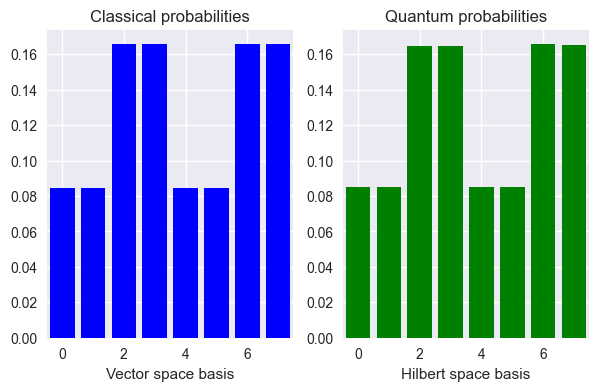

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()